# Nvidia Jestson Nano

Nvidia Jetson Nano (JN) is an embedded GPU platform that supports CUDA technology.

Board contains (among others) ports:
- HDMI(display)
- USB-C (power supply)
- 3x USB 3.0 - keyboard, mouse and more like USB camera.
- RJ-45 (ethernet) port
- micro USB port,
- GPIO ports...

JN is a computer with CPU and GPU.

Works under Linux OS control.

Support remote mode and independent - like normal PC with keyboard, mouse and display.

This exercise is based on remote mode with command line interface and web / browser through jupyter notebook server on JS board. 


Documentation, tutorials, etc.:
- https://developer.nvidia.com/embedded/learn/get-started-jetson-nano-2gb-devkit

## Part 0 - run on each device

In [26]:
# directory for MNIST dataset
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [27]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from typing import Tuple, Union


1. To be able to compare acceleration capabilities, we need to measure execution time.

Your task is to define [context manager](https://www.geeksforgeeks.org/context-manager-in-python/) class :
- class name: `TimeMeasurement`
- manager should be initialized with number of 'predicted' processed frames as `int` 

(number of processed images in context) and context name as `str` 
- when entering the context, manager should save current time
- when exiting the context, manager should save current time
- manager should calculate duration of context execution in seconds (floats) getter [property](https://www.geeksforgeeks.org/python-property-decorator-property/) `time`
- manager should calculate fps by getter property `fps` during context execution
- overload method `__str__` to display context in format `Execution time: {hours}:{minutes}:{seconds}:{milliseconds}, processed {frames_num} frames, throughput: {fps} fps.`
- overload method `__repr__` to display context in format `TimeMeasurement(context="{context_name}","{hours}:{minutes}:{seconds}:{milliseconds}", frames={frames_num}, throughput={fps})`

Node: Prevent situation when properties `time` and `fps` are called, 

when context is still not closed or not opened (when there is no time data of beginning and ending of context).

In this situation raise RuntimeError exception.
 

In [33]:
import time
import traceback

class TimeMeasurement:
    def __init__(self, context_name: str, frames: int):
        self.context_name = context_name
        self.frames = frames
        # use passed arguments or None
  
    # context methods
    def __enter__(self):
        self.start_time = time.time()
        self.comput_time = time.process_time()
        return self
 
    def __exit__(self, exc_type, exc_value, tb):
        if exc_type is not None:
            traceback.print_exception(exc_type, exc_value, tb)
        # return False # uncomment to pass exception through

        return True
        
    # time and fps properties
    @property
    def time(self):
        return time.time() - self.start_time
    @property
    def fps(self):
        return 1.0 / (time.time() - self.start_time)
    # __str__ and __repr__ methods
    def __str__(self) -> str:
        return f"Execution time: {self.time}, processed {self.frames} frames, throughput: {self.fps} fps."
    def __repr__(self) -> str:
        return f"TimeMeasurement(context={self.context_name}, {self.time} , frames={self.frames}"

2. Test defined context manager by running in context 1000 for loop iterations with `time.sleep` of `1 ms`. 


In [34]:
tm = TimeMeasurement("Test",1000)

with tm:
   for i in range(0,10):
      time.sleep(1)
        

print("fps = ", tm.fps ,"[fps]") # print fps properties values
print("time = ", tm.time , "[s]") # print time properties values
print(repr(tm))
print(str(tm))


fps =  0.09989488218974289 [fps]
time =  10.012626886367798 [s]
TimeMeasurement(context=Test, 10.01279902458191 , frames=1000
Execution time: 10.01291036605835, processed 1000 frames, throughput: 0.09987100572909431 fps.


Creating evaluation dataloaders.

In [ ]:
eval_dataset = datasets.MNIST('data', 
                              train=False,
                              download=True,
                              transform=ToTensor())
eval_loader = DataLoader(eval_dataset, 
                          batch_size=1, # batch size of 1 for real time processing
                          shuffle=False)
print("len(eval_loader) =", len(eval_loader))

Defining a model 

In [29]:
import local_utils 

class ResidualBlock(nn.Module):
    def __init__(self, 
                 input_channels: int,
                 intermediate_channels: int,
                 kernel_size: Union[int, Tuple[int,int]],                  
                 ) -> None:
        super().__init__()
        self.L1 = nn.Sequential(nn.Conv2d(in_channels=input_channels, 
                                          out_channels=intermediate_channels, 
                                          kernel_size=kernel_size, 
                                          bias=False, 
                                          padding=kernel_size//2),
                                nn.BatchNorm2d(intermediate_channels),
                                nn.ReLU()
                                )
        self.L2 = nn.Sequential(nn.Conv2d(in_channels=intermediate_channels, 
                                          out_channels=input_channels, 
                                          kernel_size=kernel_size, 
                                          bias=False, 
                                          padding=kernel_size//2),
                                nn.BatchNorm2d(input_channels),
                                nn.ReLU()
                                )
        
    def forward(self, 
                x: torch.Tensor) -> torch.Tensor:
        return x + self.L2(self.L1(x))


class MiniResNet(nn.Module):
    def __init__(self, 
                 input_shape=(1,28,28),
                 num_of_classes=10,
                 ) -> None:
        super().__init__()
        self.CNN = nn.Sequential(
                                nn.Conv2d(input_shape[0], 16, 3, padding=1),
                                nn.ReLU(),
                                
                                ResidualBlock(16,4,3),
                                
                                nn.Conv2d(16, 32, 3, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(2,2),
                                
                                ResidualBlock(32,4,3),
                                ResidualBlock(32,2,3),
                                
                                nn.Conv2d(32, 64, 3, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(2,2),
                                
                                ResidualBlock(64,8,3),
                                ResidualBlock(64,16,3),
                                
                                nn.Conv2d(64, 128, 3),
                                nn.ReLU(),
                                
                                nn.Conv2d(128, 128, 3),
                                nn.ReLU(),
                                )
        CNN_out_shape = [
                         128,
                         input_shape[-2]//2//2 - 3//2*2 - 3//2*2,
                         input_shape[-1]//2//2 - 3//2*2 - 3//2*2
                        ]
        CNN_flatten_len = torch.prod(torch.tensor(CNN_out_shape))
        
        self.FC = nn.Sequential(
                               nn.Flatten(),
                               nn.Linear(CNN_flatten_len, num_of_classes),
                               nn.Softmax(1),
                               )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.FC(self.CNN(x))
        

net = MiniResNet((1,28,28), 10)

print(f"Num of parameter: {local_utils.count_params(net)}")

Num of parameter: 289006


Accuracy metric  and cross entropy loss.

In [30]:
metric = local_utils.AccuracyMetic()
criterion = torch.nn.CrossEntropyLoss()

## Part 1 - TRAINING

Cells in this section run only when you are on host device - PC. 

len(train_loader) = 938
len(test_loader) = 157
torch.Size([64, 1, 28, 28])
torch.Size([64])


<Figure size 432x288 with 0 Axes>

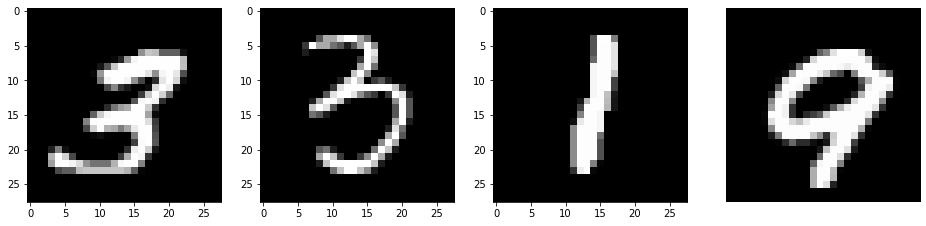

In [42]:
BATCH_SIZE = 64

train_dataset = datasets.MNIST('data', 
                              train=True,
                              download=True,
                              transform=ToTensor())
test_dataset = datasets.MNIST('data', 
                              train=False,
                              download=True,
                              transform=ToTensor())

train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE,
                          shuffle=True)
test_loader = DataLoader(test_dataset, 
                          batch_size=BATCH_SIZE,
                          shuffle=False)
print("len(train_loader) =", len(train_loader))
print("len(test_loader) =", len(test_loader))

plt.gray()
loader = train_loader
for X, y in loader:
    print(X.shape)
    print(y.shape)
    
    ROWS, COLS = 1, 4
    fig, axs = plt.subplots(ROWS, COLS)
    fig.set_size_inches(COLS*4,ROWS*4)
    axs = np.array(axs).flatten().tolist()
    
    for i, ax in enumerate(axs):
        img = X[i,...]
        class_label = loader.dataset.classes[y[i]]
        ax.imshow(img.squeeze())
        plt.axis(False)
    plt.show()
    break

3. Train the network with:
- SGD optimizer
- learning rate 0.1
- update period of 5
- 5 epochs

Plot history and print.

cpu
Epoch 1 / 1: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [03:21,  4.65it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:12, 12.44it/s]


After epoch 1: loss=1.4892 acc=0.9731 val_loss=1.4853 val_acc=0.9773
Epoch 1 / 1: FINISHED



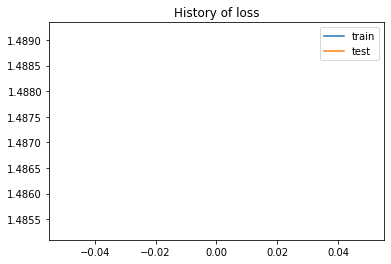

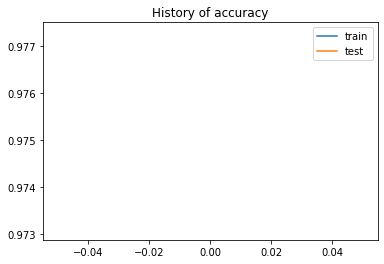

In [35]:
metric = local_utils.AccuracyMetic()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

net.to(device)
net, history = local_utils.training(model=net,
train_loader=train_loader,
test_loader=test_loader,
loss_fcn=criterion,
metric=metric,
optimizer=optimizer,
update_period=1,
epoch_max=1,
device=device)

local_utils.plot_history(history)

4. Extract model state dict and save it in file `weights.pth`.

In [36]:
sd = net.state_dict()
torch.save(sd, 'weights.pth')

## Part 2 - EVALUATION - host device
Do not run cells from this section on Jetson Nano (to avoid output overwriting)

5. Instantiate `MiniResNet` network with the same input shape.

Load state dict from `weights.pth` file and initialize with them network (`load_state_dict`, with `map_location=device`).  

Evaluate model on `eval_loader` dataset with `local_utils.train_test_pass`.

Print information about loss, accuracy, time of execution, number of processed images and throughput (fps).

Experiment do for 'cpu' and for 'cuda' devices.

In [37]:
# CUDA - GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
# load sd with mapping location to device
sd = torch.load("weights.pth")
# create net and move it to device
net = MiniResNet().to(device)
# load state dict to net
net.load_state_dict(sd)

tm = TimeMeasurement("Host-GPU", len(eval_loader))
with tm:
    net,loss,acc =local_utils.train_test_pass(net,data_generator=eval_loader,criterion=criterion,metric=metric,device=device)

    # evaluate model on device use local_utils.train_test_pass
    
print(repr(tm))
print("loss:", loss)
print("acc:", acc)

Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


10000it [00:42, 233.99it/s]

TimeMeasurement(context=Host-GPU, 42.74663186073303 , frames=10000
loss: 1.4852898340940475
acc: 0.9773


In [39]:
# CPU
device = "cpu"
# load sd with mapping location to device
sd = torch.load("weights.pth")
# create net and move it to de  vice
net = MiniResNet().to(device)
# load state dict to net
net.load_state_dict(sd)

tm = TimeMeasurement("Host-CPU", len(eval_loader))

with tm:
    net,loss,acc =local_utils.train_test_pass(net,
                                              eval_loader,
                                              criterion,
                                              metric,
                                              device)
    # evaluate model on device use local_utils.train_test_pass
    
print(repr(tm))
print("loss:", loss)
print("acc:", acc)

Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


10000it [00:41, 239.21it/s]

TimeMeasurement(context=Host-CPU, 41.814099073410034 , frames=10000
loss: 1.4852898340940475
acc: 0.9773


## Part 3 - Connection - Jetson Nano - for the next lab 01.12.2022

To connect with Jetson Nano board (JNb):

1 ) Connect Power supplier plugin to the socket and USB-C plugin to the board.

2 ) On the host side run command in terminal:

`dmesg | grep --color 'tty'`

This should print all USB devices.
     
3 ) Connect micro USB cable between PC and JNb.

4 ) Run again command from `2)`. 

Find new device - that's Jetson Nano!

Output should look similar to:

`[xxxxxx.xxxxxx] cdc_acm 1-5:1.2: ttyACM0: USB ACM device`

`ttyACM0` is USB device name.

5 ) Run command:

`ls -l /dev/ttyACM0`

Output should look similar to:

`crw-rw---- 1 root dialout 166, 0 Oct  2 02:45 /dev/ttyACM0`

6 ) Install `screen`:

`sudo apt-get update`

`sudo apt install screen`

7 ) Connect with JNb:

`sudo screen /dev/ttyACM0 115200`

8 ) Now you are in the remote terminal of JNb.

9 ) Run Jupyter server on the board:

`jupyter notebook`

10 ) Open displayed link in browser.

11 ) Create your own directory structure (the final path name should be `$DIR_NAME = ./eAI/{your_name}/lab8` relatively to main the root directory of server).

12 ) Now save this file and upload it to JNb by browser interface to `$DIR_NAME` directory.

13 ) Upload also `data` directory, `local_utils.py` and saved `weights.pth` file to `$DIR_NAME` directory. 


## Part 4 - EVALUATION - Jetson Nano device

6. Instantiate `MiniResNet` network with the same input shape.

Load state dict from `weights.pth` file and initialize with them network (`load_state_dict`).  

Evaluate model on `eval_loader` dataset with `local_utils.train_test_pass` on Jetson Nano Device.

Print information about loss, accuracy, time of execution, number of processed images and throughput (fps).

Experiment do for 'cpu' and for 'cuda' devices.

In [40]:
# CPU
device = "cpu"
# load sd with mapping location to device
sd = torch.load("weights.pth")
# create net and move it to device
net = MiniResNet().to(device)
# load state dict to net
net.load_state_dict(sd)

tm = TimeMeasurement("Jetson Nano - CPU", len(eval_loader))

with tm:
    net,loss,acc =local_utils.train_test_pass(net,
                                              eval_loader,
                                              criterion,
                                              metric,
                                              device)
    # evaluate model on device use local_utils.train_test_pass
    
print(repr(tm))
print("loss:", loss)
print("acc:", acc)

Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


10000it [00:38, 259.12it/s]

TimeMeasurement(context=Jetson Nano - CPU, 38.60445833206177 , frames=10000
loss: 1.4852898340940475
acc: 0.9773


In [41]:
# CUDA - GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
# load sd with mapping location to device
sd = torch.load("weights.pth")
# create net and move it to device
net = MiniResNet().to(device)
# load state dict to net
net.load_state_dict(sd)

tm = TimeMeasurement("Jetson Nano - GPU", len(eval_loader))

with tm:
        net,loss,acc =local_utils.train_test_pass(net,
                                              eval_loader,
                                              criterion,
                                              metric,
                                              device)
    # evaluate model on device use local_utils.train_test_pass
    
print(repr(tm))
print("loss:", loss)
print("acc:", acc)

Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


10000it [00:44, 223.08it/s]

TimeMeasurement(context=Jetson Nano - GPU, 44.8366174697876 , frames=10000
loss: 1.4852898340940475
acc: 0.9773


7. Copy / download notebook from Jetson Nano Device to Host PC by web/browser interface or via ftp.


8. You can leave a feedback, if you want :)

9. Exercises please upload notebook WITH ALL OUTPUTS to UPEL.